# Analysis of Gaussian process output

This notebook is used to analyze the Gaussian process output from the file `gp_pipeline.jl`

# Setup and load data

In [31]:
using CSV, DataFrames, Distributions,StatsBase, PythonPlot,Random,CausalityTools

In [2]:
preds = []
params = []
pred_dir = "./../output/output_7-24-24"
files = readdir(pred_dir)
for f in files
    df = CSV.read(pred_dir*"/"*f*"/preds.csv",DataFrame)
    push!(preds,df)
    push!(params,CSV.read(pred_dir*"/"*f*"/opt_params.csv",DataFrame))
end

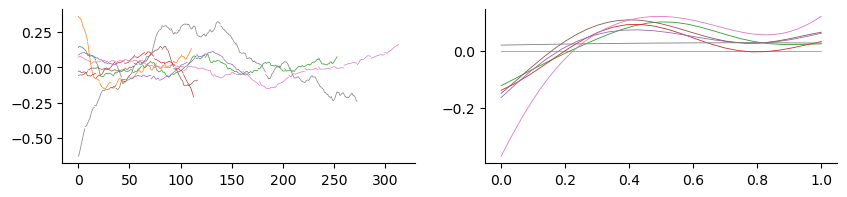

In [63]:
fig,axs = subplots(figsize=(10,2),ncols=2)

ax = axs[0]
for k in 1:length(preds)
    df = preds[k]
    for p in unique(df.position)
        ax.plot(df[df.position .==p,:time],df[df.position .==p,:matern32_flucs],"C"*string(k)*"-",lw=0.5)
    end
end

ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)

ax = axs[1]
for k in 1:length(preds)
    df = preds[k]

    age = df[df.position .==1,:time] .- df[df.position .==1,:time][1]
    age = age ./ age[end]
    ax.plot(age,df[df.position .==1,:matern32_cell_x],"C"*string(k)*"-",lw=0.6)
end

ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)


fig

# MSD

In [79]:

(x .- x').^2

X = [df[df.position .==p,:matern32_flucs_x] for p in unique(df.position)]


[(x .- x').^2 for x in X ]



19-element Vector{Matrix{Float64}}:
 [0.0 4.954838124788821e-5 … 3.891572330536258e-5 0.0001321210370790023; 4.954838124788821e-5 0.0 … 6.413035304769047e-7 1.9849969359137802e-5; … ; 3.891572330536258e-5 6.413035304769047e-7 … 0.0 2.762705747993789e-5; 0.0001321210370790023 1.9849969359137802e-5 … 2.762705747993789e-5 0.0]
 [0.0 3.8729647564256947e-7 … 3.824337993845455e-7 4.741839007160356e-6; 3.8729647564256947e-7 0.0 … 1.539445190221648e-6 7.8394841950816e-6; … ; 3.824337993845455e-7 1.539445190221648e-6 … 0.0 2.430992644676719e-6; 4.741839007160356e-6 7.8394841950816e-6 … 2.430992644676719e-6 0.0]
 [0.0 6.092144141783907e-7 … 2.1803873223097913e-5 1.7000693533261625e-5; 6.092144141783907e-7 0.0 … 1.5123853424430762e-5 1.1173428303568736e-5; … ; 2.1803873223097913e-5 1.5123853424430762e-5 … 0.0 2.9841314403533886e-7; 1.7000693533261625e-5 1.1173428303568736e-5 … 2.9841314403533886e-7 0.0]
 [0.0 6.934247288570671e-7 … 3.8589499146178436e-5 4.4653442441820534e-5; 6.934247288570671e-7

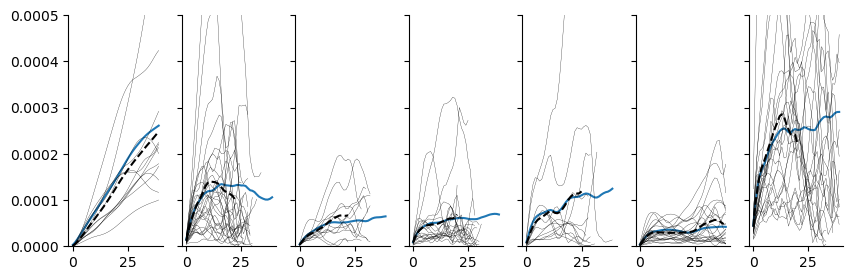

In [160]:



fig,axs = subplots(figsize=(10,3),ncols = length(preds),sharex=true,sharey=true)

for k in 1:length(preds)
    ax = axs[k-1]
    df = preds[k]
    x = df.matern32_flucs_x
    msd = MSD(x,40)
    ax.plot(msd)
    mw = []
    for p in unique(df.position)
        xw = df[df.position .==p,:matern32_flucs_x]
        y = MSD(xw,40)
        push!(mw,y)
        ax.plot(y,"k-",lw=0.2)
    end
    mw = hcat(mw...)
    ax.plot(mean(mw,dims=2),"k--")
    ax.set_ylim([0.,0.0005])
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
end
fig


In [123]:
xw = df[df.position .==2,:matern32_flucs_x]
mw = msd(xw,5)

MethodError: MethodError: objects of type Vector{Float64} are not callable
Use square brackets [] for indexing an Array.

In [111]:
function MSD(x,max_steps)
    n = length(x)
    msd = zeros(max_steps)
    for i in 1:max_steps 
        msd[i] = mean((x[1:end-i] .- x[i+1:end]).^2)
    end
    return msd
end


MSD (generic function with 1 method)

In [ ]:

fig,ax = subplots(figsize=(10,2))
ax.imshow((x .- x').^2)
fig

# Causality

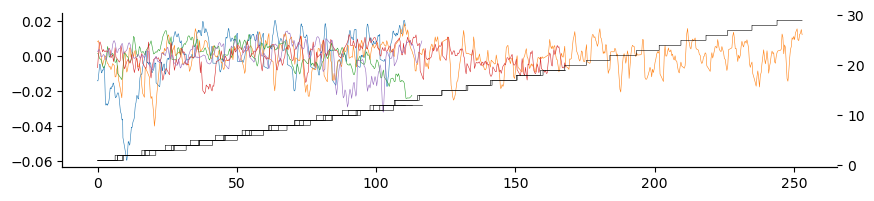

In [58]:
fig,ax = subplots(figsize=(10,2))
ax2 =ax.twinx()
for k in 1:5
    df = preds[k]
    ax.plot(df.time,df.matern32_flucs_x,"-",lw=0.4)
    #ax.plot(df.time,df.matern32_cell_x,"-")

    ax2.step(df.time,df.position,"k-",lw=0.4)
end

ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax2.spines["right"].set_visible(false)
ax2.spines["top"].set_visible(false)
fig